## Packages Overview

### spekpy
[Overview](https://bitbucket.org/spekpy/spekpy_release/wiki/Home)

[Glossary](https://bitbucket.org/spekpy/spekpy_release/wiki/Function%20glossary)

### xraydb
[Overview](https://xraypy.github.io/XrayDB/)


In [1]:
from spectrumEstimations import SpekEstimations

import numpy as np
import matplotlib.pyplot as plt
import spekpy as sp
import xraydb
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
from roentgen.absorption import MassAttenuationCoefficient

# User-Defined Parameters

In [2]:
## Scanner Parameters
kvp = 140. # Tube potential [kV] 
theta = 10.5 # Anode angle [deg.]
dx = 2. # Increment in lateral direction (= 0.5 in book figures) [cm]
z = 62.56 # Source-to-dector distance [cm]
dk = 0.5  # Width of energy bin [keV] 
numPhotons = np.random.poisson(10**6)

#Crop EnergyBin
cropMin = 5

## Phantom Parameters
materials  = ['Al']
phantomLengths = np.linspace(0.136,4,7,endpoint=True)



# Set Initial Guess

In [3]:
## Get initial W guess
initialGuessObject = sp.Spek(th=theta,kvp=kvp,physics="kqp",char=False,obli=False)
initialGuessObject.multi_filter([('W',0.1)]) ## Tungsten Filter
Es, initialGuess = initialGuessObject.get_spectrum(addend=True)
Es = Es[cropMin:]
initialGuess=initialGuess[cropMin:]
initialGuess = initialGuess/np.sum(initialGuess)*numPhotons
initialGuess[initialGuess==0] = 1

# Simulate Spectrum (Simulation Mode Only)

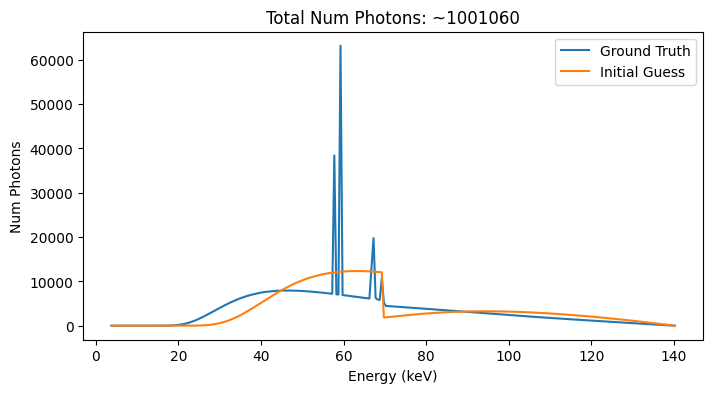

In [4]:
## Load Spectrum
spectrum = sp.Spek(th=theta,kvp=kvp,physics="kqp",char=True,obli=False)
spectrum.filter('Al',1.94)
spectrum.multi_filter([('C',1.94), ('Al',0.19), ('Cu',0.07)])
Es,spectra = spectrum.get_spectrum(addend=True)
spectra = spectra[cropMin:]
Es = Es[cropMin:]
groundTruth = spectra/np.sum(spectra)*numPhotons
groundTruth[groundTruth==0] = 1

groundTruth1 = groundTruth

plt.figure(figsize=(8,4))
plt.plot(Es, groundTruth, label="Ground Truth")
plt.plot(Es,initialGuess,label="Initial Guess",linestyle="-")
plt.title("Total Num Photons: ~{}".format(numPhotons))
plt.ylabel("Num Photons")
plt.xlabel("Energy (keV)")
plt.legend()
plt.show()

# Estimate Spectrum

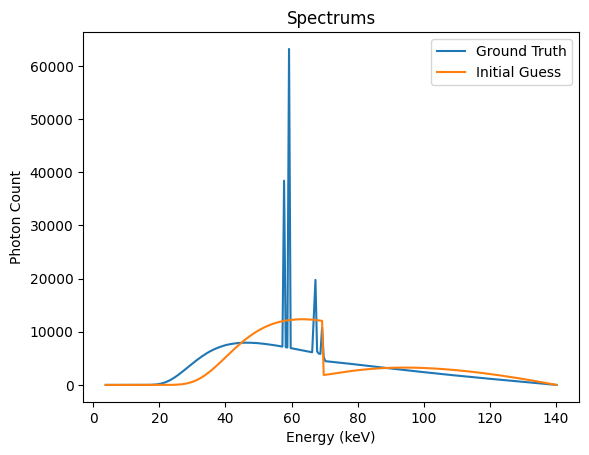

<Figure size 640x480 with 0 Axes>

In [5]:
estimationObj = SpekEstimations(materials,phantomLengths,initialGuess,Es,groundTruth)
estimateWs = estimationObj.getSpectrum()
#estimationObj.plotSpectrum()


# Plotting Code
Number of plots is hardcoded so if you change number of measurements you will need to change the subplot configuration. 

In [6]:
np.shape(estimateWs)

(8, 274)

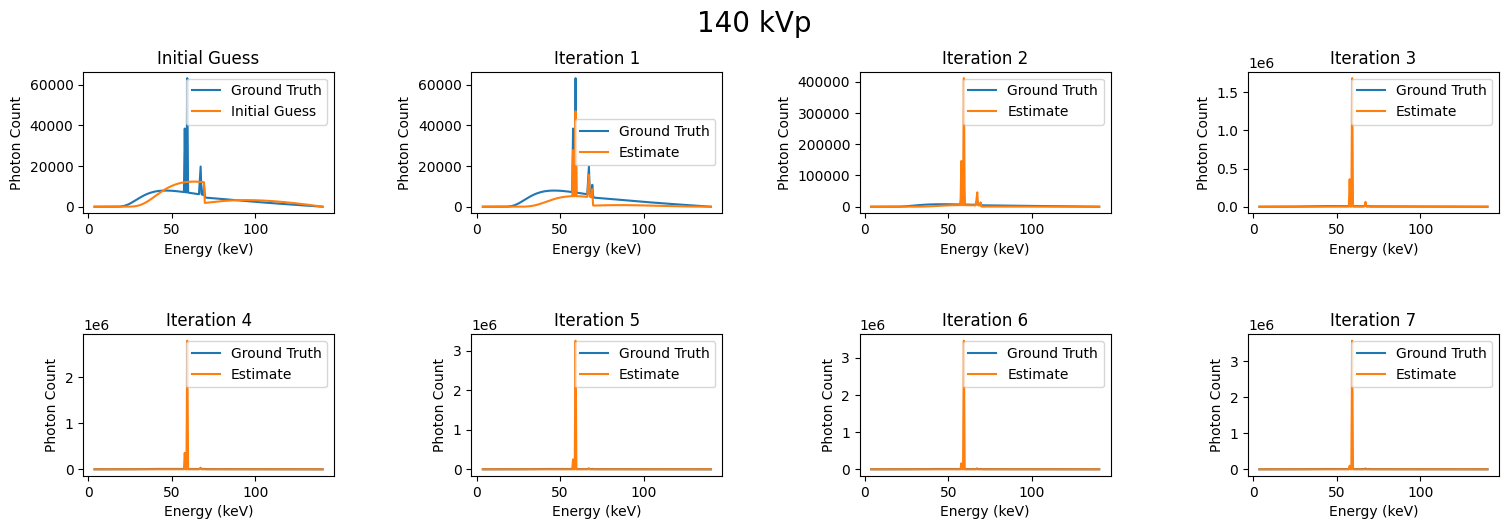

In [7]:
plt.figure(figsize=(16,8))
for i in range(len(estimateWs)):
    plt.subplot(3,4, i+1)
    plt.plot(Es, groundTruth)
    plt.plot(Es, estimateWs[i])
    plt.xlabel("Energy (keV)")
    plt.ylabel("Photon Count")
    if i == 0:
        plt.title("Initial Guess")
        plt.legend(labels=["Ground Truth","Initial Guess"])
    else:
        plt.title("Iteration {}".format(i))
        plt.legend(labels=["Ground Truth","Estimate"])
plt.tight_layout(pad=4.0)
plt.suptitle("{} kVp".format(int(kvp)), fontsize=20)
plt.show()

(-10.0, 30000.0)

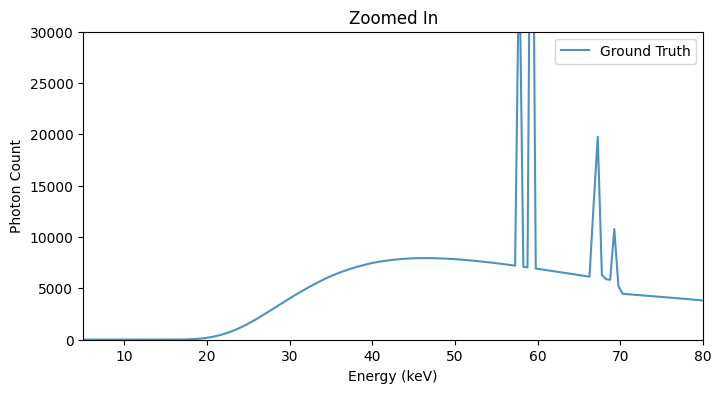

In [8]:
estimate = estimateWs[-1]
plt.figure(figsize=(8,4))
plt.plot(Es, groundTruth, label="Ground Truth", alpha=0.8)
##plt.plot(Es, estimateWs[3],label="Iteration 3",alpha=0.5)
##plt.plot(Es, estimateWs[18],label="Iteration 18",alpha=0.5)


plt.xlabel("Energy (keV)")
plt.ylabel("Photon Count")
plt.title("Zoomed In")

plt.legend()

plt.xlim(5,80)
plt.ylim(-10,30000)

# Extra Code

In [9]:
#import astropy.units as u
#from astropy.visualization import quantity_support
#quantity_support()
#from roentgen.absorption import MassAttenuationCoefficient

# plot = True
# ## Preparing Mu values
# materialMus =np.zeros((len(materials), len(Es)))
# for i in range(len(materials)):
#     mus_0 = np.loadtxt(materials[i][0]+".txt")[:,:2]
#     mus_0[:,0] = mus_0[:,0]*10**3
#     materialMus[i] = np.interp(Es,mus_0[:,0],mus_0[:,1])
#     if plot:
#         fig = plt.figure()
#         plt.subplot(1,3,1)
#         plt.plot(mus_0[:,0], mus_0[:,1])
#         plt.yscale("log")
#         plt.xscale("log")
#         plt.xlabel('Energy [keV]')
#         plt.ylabel('Mass attenuation Coefficient [cm^2/g]')
#         plt.title(materials[i][0])
        
#         plt.subplot(1,3,2)
#         plt.plot(Es, materialMus[i])
#         plt.yscale("log")
#         plt.xscale("log")
#         plt.xlabel('Energy [keV]')
#         plt.ylabel('Mass attenuation Coefficient [cm^2/g]')
#         plt.title(materials[i][0])

#         plt.subplot(1,3,3)
#         plt.plot(Es, materialMus[i]*materials[i][1] )
#         plt.yscale("log")
#         plt.xscale("log")
#         plt.xlabel('Energy [keV]')
#         plt.ylabel('Mass attenuation Coefficient [1/cm]')
#         plt.title(materials[i][0])
#         fig.tight_layout()